# Meta-Eval Summariser

Interactive notebook version of `summarise_meta_eval.py`. Use this to explore one or many `_meta_eval.json` files without leaving Jupyter.

In [1]:
from __future__ import annotations

import json
from pathlib import Path
from typing import Dict, List, Tuple, Optional, Set


def parse_meta_file_args(items: List[str]) -> List[Tuple[Optional[str], Path]]:
    """Parse inputs in optional TAG:PATH format (directories supported)."""
    parsed: List[Tuple[Optional[str], Path]] = []
    for item in items:
        if ":" in item:
            tag, path_str = item.split(":", 1)
        else:
            tag, path_str = None, item
        path = Path(path_str).expanduser().resolve()
        if path.is_dir():
            json_files = sorted(path.glob("*.json"))
            if not json_files:
                raise FileNotFoundError(f"No JSON files under directory '{path}'")
            for file in json_files:
                parsed.append((tag, file))
        else:
            parsed.append((tag, path))
    return parsed


def infer_method_cluster(path: Path, methods: List[str], clusters: List[int]) -> Tuple[str, int]:
    name = path.stem
    matches: List[Tuple[str, int]] = []
    for method in methods:
        idx = name.find(method)
        while idx != -1:
            start = idx + len(method)
            digits = []
            while start < len(name) and name[start].isdigit():
                digits.append(name[start])
                start += 1
            if digits:
                matches.append((method, int("".join(digits))))
            idx = name.find(method, idx + 1)
    if not matches:
        raise ValueError(f"Cannot infer method/n_clusters from '{path.name}'.")
    matches = list(dict.fromkeys(matches))
    if len(matches) > 1:
        raise ValueError(f"Ambiguous method tokens in '{path.name}': {matches}")
    method, cluster = matches[0]
    if clusters and cluster not in clusters:
        raise ValueError(f"Cluster {cluster} for '{path.name}' not in allowed {clusters}")
    return method, cluster


def derive_tag_main(
    path: Path,
    method: str,
    cluster: int,
    override: Optional[str] = None,
    allowed_tags: Optional[Set[str]] = None,
) -> str:
    if override:
        return override
    stem = path.stem
    if stem.endswith("_meta_eval"):
        stem = stem[:-len("_meta_eval")]
    token = f"_{method}{cluster}"
    candidate = stem[:-len(token)] if stem.endswith(token) else stem
    if allowed_tags:
        for tag in allowed_tags:
            if candidate == tag or candidate.startswith(tag):
                return tag
        raise ValueError(f"Inferred tag '{candidate}' not in --tags {sorted(allowed_tags)}")
    return candidate


def filter_metrics(raw_metrics: Dict[str, object], selected: List[str]) -> Dict[str, object]:
    if not selected:
        return raw_metrics
    return {metric: raw_metrics[metric] for metric in selected if metric in raw_metrics}


def summarise_meta_eval_interactive(
    meta_files: List[str],
    *,
    clustering_methods: List[str],
    cluster_counts: List[int],
    metrics: Optional[List[str]] = None,
    allowed_tags: Optional[List[str]] = None,
) -> Dict[str, Dict[str, Dict[str, Dict[str, object]]]]:
    entries_raw = parse_meta_file_args(meta_files)
    entries = [
        (tag_override, path)
        for tag_override, path in entries_raw
        if path.name != "meta_eval_summary.json"
    ]
    metrics_to_keep = metrics or []
    allowed_set = set(allowed_tags) if allowed_tags else None

    summary: Dict[str, Dict[str, Dict[str, Dict[str, object]]]] = {}
    for tag_override, path in entries:
        if not path.exists():
            raise FileNotFoundError(f"Meta eval file not found: {path}")
        with path.open("r", encoding="utf-8") as handle:
            data = json.load(handle)
        method, cluster = infer_method_cluster(path, clustering_methods, cluster_counts)
        cleaned = filter_metrics(data, metrics_to_keep)
        tag_main = derive_tag_main(path, method, cluster, override=tag_override, allowed_tags=allowed_set)
        summary.setdefault(tag_main, {}).setdefault(method, {})[str(cluster)] = cleaned
    return summary



## Example usage

Fill in the paths/tags that match your run and execute the next cell.

In [11]:
# Example placeholder arguments.
# Replace strings below with real directories or TAG:PATH pairs.
meta_inputs = [
    "/home/wslqubuntu24/Research/Data/1_Foundation_MVT_Result/2_UFM_v2/TransAggDCCA_Ex1_dim256/cls_1_training_results/meta_evaluation_results",  # directory (all *.json will be processed)
]

summary = summarise_meta_eval_interactive(
    meta_files=meta_inputs,
    clustering_methods=["random", "kmeans", "hierarchical"],
    cluster_counts=[2, 3,  4, 6, 8, 10],
    metrics=["PosDrop_Acc", "Focus", "topk", "pauc", "pu_tpr", "pu_fpr", "pu_npv", "background_rejection"],
    allowed_tags=["base_MAEViT_BC", "Method2_concat_MAEViT_plus_TransDCCA_BC"],
)

summary

{'Method2_concat_MAEViT_plus_TransDCCA_BC': {'hierarchical': {'10': {'PosDrop_Acc': {'scores': [0.9755830764770508,
      0.991415798664093,
      0.83291095495224,
      0.9913991689682007,
      0.9999979734420776,
      0.9992622137069702,
      0.9999669194221497,
      0.999970018863678,
      0.9968758821487427,
      0.9999969005584717],
     'mean': 0.9787378907203674,
     'std': 0.04914481811339815,
     'scores_info': {'count': 10,
      'description': 'Per-iteration metric values (one entry per positive-drop fold).'}},
    'Focus': {'scores': [0.8485682010650635,
      0.8574463725090027,
      0.8428748846054077,
      0.8302947282791138,
      0.8124513030052185,
      0.8297802805900574,
      0.8366970419883728,
      0.8589334487915039,
      0.8262746334075928,
      0.8291705846786499],
     'mean': 0.8372491478919983,
     'std': 0.01393913799586432,
     'scores_info': {'count': 10,
      'description': 'Per-iteration metric values (one entry per positive-drop fold

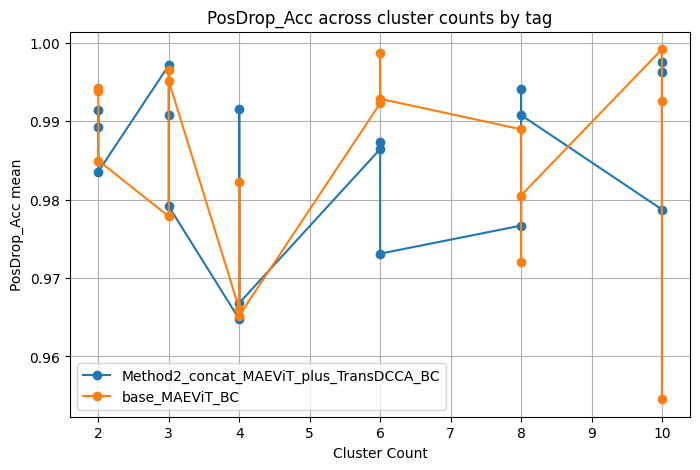

In [12]:
import matplotlib.pyplot as plt

def extract_metric(summary_dict, metric_name: str):
    rows = []
    for tag_main, methods_dict in summary_dict.items():
        for method, clusters_dict in methods_dict.items():
            for cluster, metrics in clusters_dict.items():
                metric = metrics.get(metric_name)
                if isinstance(metric, dict) and isinstance(metric.get('mean'), (int, float)):
                    rows.append((tag_main, method, int(cluster), float(metric['mean'])))
    return rows

metric_rows = extract_metric(summary, 'PosDrop_Acc')
if not metric_rows:
    raise RuntimeError("No scalar 'PosDrop_Acc' mean values found.")

by_tag = {}
for tag, method, cluster, mean_value in metric_rows:
    by_tag.setdefault(tag, []).append((cluster, mean_value))

plt.figure(figsize=(8, 5))
for tag, entries in by_tag.items():
    entries.sort(key=lambda x: x[0])
    clusters = [c for c, _ in entries]
    values = [v for _, v in entries]
    plt.plot(clusters, values, marker='o', label=tag)

plt.xlabel('Cluster Count')
plt.ylabel('PosDrop_Acc mean')
plt.title('PosDrop_Acc across cluster counts by tag')
handles, labels = plt.gca().get_legend_handles_labels()
if handles:
    plt.legend()
plt.grid(True)
plt.show()


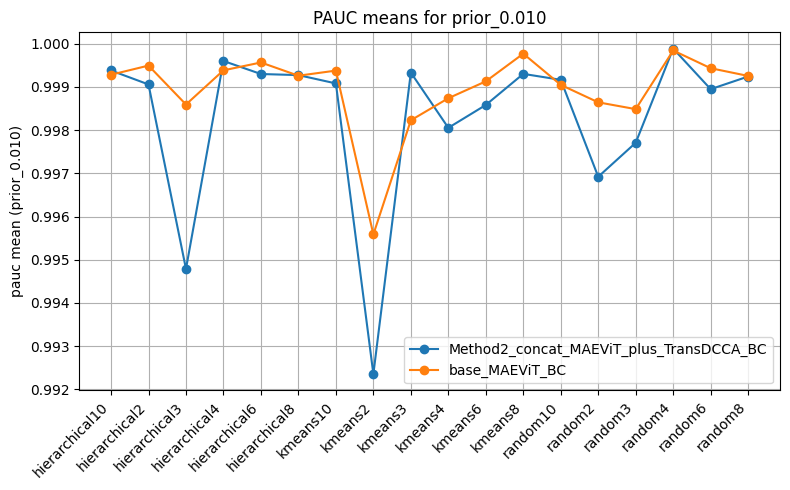

In [13]:
import matplotlib.pyplot as plt

def plot_pauc(summary_dict, prior_key='prior_0.010'):
    by_tag = {}
    for tag_main, methods_dict in summary_dict.items():
        entries = []
        for method, clusters_dict in methods_dict.items():
            for cluster, metrics in clusters_dict.items():
                entry = metrics.get('pauc', {}).get(prior_key)
                if isinstance(entry, dict) and isinstance(entry.get('mean'), (int, float)):
                    entries.append((f'{method}{cluster}', float(entry['mean'])))
        if entries:
            by_tag[tag_main] = entries
    if not by_tag:
        raise RuntimeError(f'No PAUC data found for {prior_key}.')
    plt.figure(figsize=(8, 5))
    for tag, entries in by_tag.items():
        entries.sort(key=lambda x: x[0])
        labels = [label for label, _ in entries]
        values = [val for _, val in entries]
        plt.plot(labels, values, marker='o', label=tag)
    plt.ylabel(f'pauc mean ({prior_key})')
    plt.xticks(rotation=45, ha='right')
    plt.title(f'PAUC means for {prior_key}')
    handles, labels = plt.gca().get_legend_handles_labels()
    if handles:
        plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_pauc(summary, prior_key='prior_0.010')


ratio_entry: {'capture_rates': [0.0, 0.05, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'precisions': [0.0, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'mean_capture_rate': 0.005, 'std_capture_rate': 0.015, 'mean_precision': 0.01, 'std_precision': 0.03}
('Method2_concat_MAEViT_plus_TransDCCA_BC', 10, 0.005)
ratio_entry: {'capture_rates': [0.0, 0.0], 'precisions': [0.0, 0.0], 'mean_capture_rate': 0.0, 'std_capture_rate': 0.0, 'mean_precision': 0.0, 'std_precision': 0.0}
('Method2_concat_MAEViT_plus_TransDCCA_BC', 2, 0.0)
ratio_entry: {'capture_rates': [0.06666666666666667, 0.0, 0.0], 'precisions': [0.14285714285714285, 0.0, 0.0], 'mean_capture_rate': 0.022222222222222223, 'std_capture_rate': 0.03142696805273544, 'mean_precision': 0.047619047619047616, 'std_precision': 0.06734350297014738}
('Method2_concat_MAEViT_plus_TransDCCA_BC', 3, 0.022222222222222223)
ratio_entry: {'capture_rates': [0.058823529411764705, 0.0, 0.0, 0.0], 'precisions': [0.125, 0.0, 0.0, 0.0], 'mean_capture_rate': 0.014

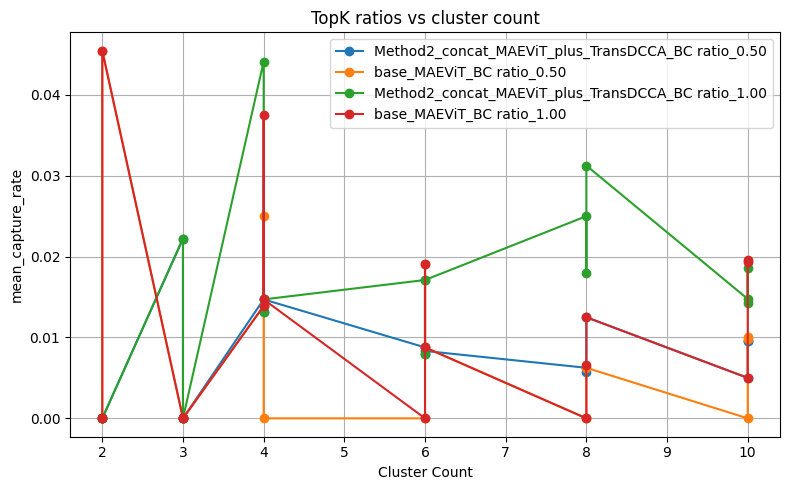

In [14]:
import matplotlib.pyplot as plt

def plot_topk_metric(summary_dict, ratio_keys=None, metric='mean_capture_rate'):
    if ratio_keys is None:
        first_tag = next(iter(summary_dict.values()))
        first_method = next(iter(first_tag.values()))
        first_clusters = next(iter(first_method.values()))
        ratio_keys = sorted(first_clusters.get('topk', {}).get('ratios', {}).keys())
    if not ratio_keys:
        raise RuntimeError('No ratio keys available in summary.')
    plt.figure(figsize=(8, 5))
    for ratio_key in ratio_keys:
        entries = []
        for tag_main, methods in summary_dict.items():
            for method, clusters_dict in methods.items():
                for cluster, metrics in clusters_dict.items():
                    ratio_entry = metrics.get('topk', {}).get('ratios', {}).get(ratio_key)
                    print("ratio_entry:", ratio_entry)
                    if isinstance(ratio_entry, dict) and isinstance(ratio_entry.get(metric), (int, float)):
                        entries.append((tag_main, int(cluster), float(ratio_entry[metric])))
                        print(entries[-1])
        if entries:
            entries.sort(key=lambda x: (x[0], x[1]))
            tags = sorted(set(tag for tag, _, _ in entries))
            for tag in tags:
                tag_entries = [entry for entry in entries if entry[0] == tag]
                clusters = [entry[1] for entry in tag_entries]
                values = [entry[2] for entry in tag_entries]
                print("clusters:", clusters)
                print("values:", values)
                plt.plot(clusters, values, marker='o', label=f"{tag} {ratio_key}")
    plt.xlabel('Cluster Count')
    plt.ylabel(metric)
    plt.title('TopK ratios vs cluster count')
    handles, labels = plt.gca().get_legend_handles_labels()
    if handles:
        plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_topk_metric(summary, ratio_keys=['ratio_0.50', 'ratio_1.00'], metric='mean_capture_rate')



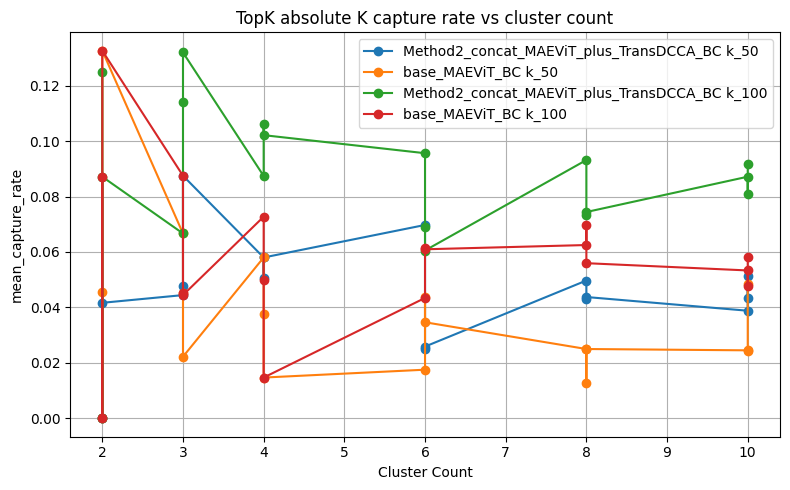

In [15]:
import matplotlib.pyplot as plt

def plot_topk_absolute(summary_dict, k_keys=None, metric='mean_capture_rate'):
    if k_keys is None:
        first_tag = next(iter(summary_dict.values()))
        first_method = next(iter(first_tag.values()))
        first_clusters = next(iter(first_method.values()))
        k_keys = sorted(first_clusters.get('topk', {}).get('absolute', {}).keys())
    if not k_keys:
        raise RuntimeError('No absolute K keys available in summary.')
    plt.figure(figsize=(8, 5))
    for k_key in k_keys:
        entries = []
        for tag_main, methods in summary_dict.items():
            for method, clusters_dict in methods.items():
                for cluster, metrics in clusters_dict.items():
                    abs_entry = metrics.get('topk', {}).get('absolute', {}).get(k_key)
                    if isinstance(abs_entry, dict) and isinstance(abs_entry.get(metric), (int, float)):
                        entries.append((tag_main, int(cluster), float(abs_entry[metric])))
        if entries:
            entries.sort(key=lambda x: (x[0], x[1]))
            tags = sorted(set(tag for tag, _, _ in entries))
            for tag in tags:
                tag_entries = [entry for entry in entries if entry[0] == tag]
                clusters = [entry[1] for entry in tag_entries]
                values = [entry[2] for entry in tag_entries]
                plt.plot(clusters, values, marker='o', label=f"{tag} {k_key}")
    plt.xlabel('Cluster Count')
    plt.ylabel(metric)
    plt.title('TopK absolute K capture rate vs cluster count')
    handles, labels = plt.gca().get_legend_handles_labels()
    if handles:
        plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_topk_absolute(summary, k_keys=['k_50', 'k_100'], metric='mean_capture_rate')



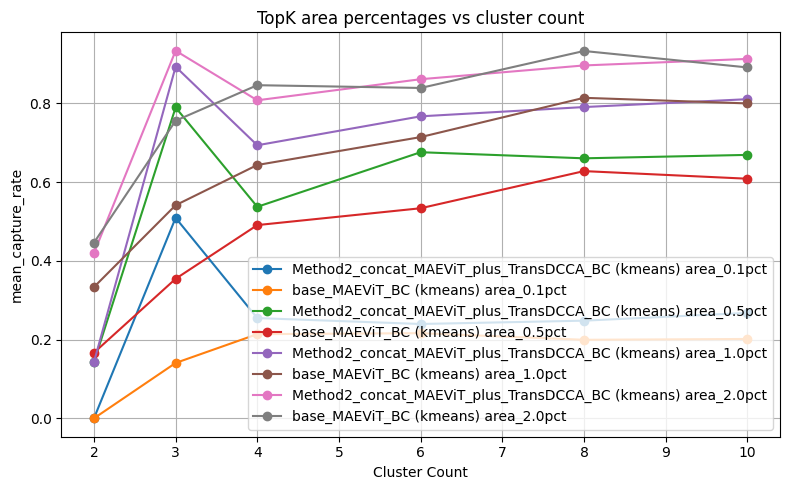

In [31]:
import matplotlib.pyplot as plt

def plot_topk_area(summary_dict, area_keys=None, metric='mean_capture_rate', include_methods=None):
    if area_keys is None:
        first_tag = next(iter(summary_dict.values()))
        first_method = next(iter(first_tag.values()))
        first_clusters = next(iter(first_method.values()))
        area_keys = sorted(first_clusters.get('topk', {}).get('area_percentages', {}).keys())
    if not area_keys:
        raise RuntimeError('No area percentage keys available in summary.')
    plt.figure(figsize=(8, 5))
    for area_key in area_keys:
        entries = []
        for tag_main, methods in summary_dict.items():
            for method, clusters_dict in methods.items():
                if include_methods and method not in include_methods:
                    continue
                for cluster, metrics in clusters_dict.items():
                    area_entry = metrics.get('topk', {}).get('area_percentages', {}).get(area_key)
                    if isinstance(area_entry, dict) and isinstance(area_entry.get(metric), (int, float)):
                        entries.append((tag_main, method, int(cluster), float(area_entry[metric])))
        if entries:
            entries.sort(key=lambda x: (x[0], x[2]))
            tags = sorted(set(entry[0] for entry in entries))
            for tag in tags:
                tag_entries = [entry for entry in entries if entry[0] == tag]
                clusters = [entry[2] for entry in tag_entries]
                values = [entry[3] for entry in tag_entries]
                methods_present = sorted(set(entry[1] for entry in tag_entries))
                label = f"{tag} {area_key}"
                if methods_present:
                    label = f"{tag} ({','.join(methods_present)}) {area_key}"
                plt.plot(clusters, values, marker='o', label=label)
    plt.xlabel('Cluster Count')
    plt.ylabel(metric)
    plt.title('TopK area percentages vs cluster count')
    handles, labels = plt.gca().get_legend_handles_labels()
    if handles:
        plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_topk_area(summary, area_keys=['area_0.1pct', 'area_0.5pct', 'area_1.0pct', 'area_2.0pct'], metric='mean_capture_rate', include_methods=['kmeans'])
# plot_topk_area(summary, area_keys=['area_0.5pct', 'area_1.0pct', 'area_2.0pct'], metric='mean_capture_rate', include_methods=["hierarchical", "random", "kmeans"])


In [55]:
import matplotlib.pyplot as plt
import numpy as np

def plot_pu_curve(
    summary_dict,
    metric_name="pu_fpr",
    include_tags=None,
    include_methods=None,
):
    include_tags = set(include_tags) if include_tags else None
    include_methods = set(include_methods) if include_methods else None

    tag_colors = {
        "base_MAEViT_BC": plt.cm.Blues,
        "Method2_concat_MAEViT_plus_TransDCCA_BC": plt.cm.Reds,
    }
    default_cmap = plt.cm.Greys

    aggregated_curves = []
    for tag, methods in summary_dict.items():
        if include_tags and tag not in include_tags:
            continue
        total_clusters = sum(len(clusters) for clusters in methods.values())
        cmap = tag_colors.get(tag, default_cmap)(np.linspace(0.3, 0.9, max(total_clusters, 1)))
        cmap_iter = iter(cmap)

        for method, clusters in methods.items():
            if include_methods and method not in include_methods:
                continue
            for cluster, metrics in clusters.items():
                block = metrics.get(metric_name)
                if not block:
                    continue
                color = next(cmap_iter, cmap[-1])
                aggregated_curves.append((tag, method, int(cluster), block, color))

    if not aggregated_curves:
        raise RuntimeError("No matching PU curves found for the specified filters.")

    plt.figure(figsize=(9, 5))
    for tag, method, cluster, block, color in aggregated_curves:
        thresholds = block["thresholds"]
        label_prefix = f"{tag} {method}{cluster}"
        if metric_name == "background_rejection":
            mean = block["mean"]
            std = block["std"]
            plt.plot(thresholds, mean, color=color, label=label_prefix)
            plt.fill_between(
                thresholds,
                [m - s for m, s in zip(mean, std)],
                [m + s for m, s in zip(mean, std)],
                color=color, alpha=0.15,
            )
        else:
            for entry in block.get("pi_stats", []):
                pi = entry["pi"]
                mean, std = entry["mean"], entry["std"]
                plt.plot(
                    thresholds,
                    mean,
                    color=color,
                    label=f"{label_prefix} π={pi}",
                )
                plt.fill_between(
                    thresholds,
                    [m - s for m, s in zip(mean, std)],
                    [m + s for m, s in zip(mean, std)],
                    color=color,
                    alpha=0.12,
                )

    plt.xscale("log")
    plt.xlabel("Threshold")
    plt.ylabel(f"{metric_name} mean")
    plt.title(f"{metric_name}: combined view")
    handles, labels = plt.gca().get_legend_handles_labels()
    if handles:
        plt.legend(loc='best', fontsize='small')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

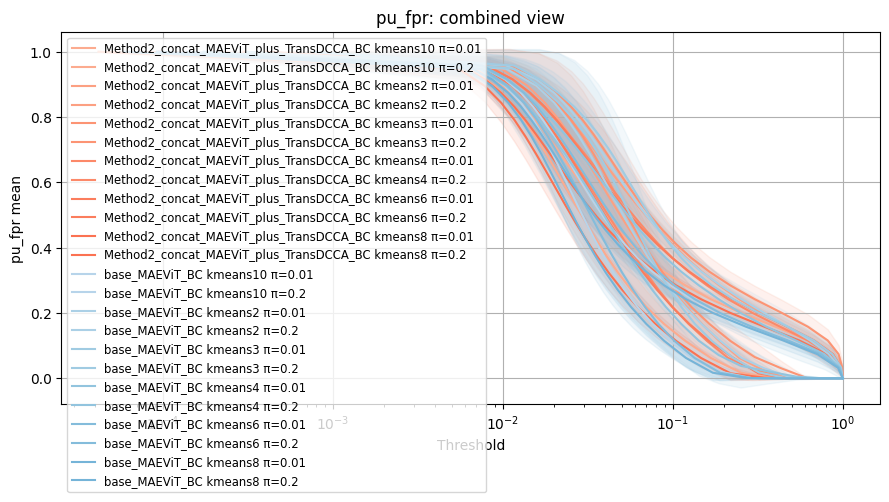

In [56]:
# plot_pu_curve(summary, metric_name="pu_fpr", include_tags=["base_MAEViT_BC", "Method2_concat_MAEViT_plus_TransDCCA_BC"],
#               include_methods=["random", "kmeans", "hierarchical"],)

plot_pu_curve(summary, metric_name="pu_fpr", include_tags=["base_MAEViT_BC", "Method2_concat_MAEViT_plus_TransDCCA_BC"],
              include_methods=["kmeans"],)

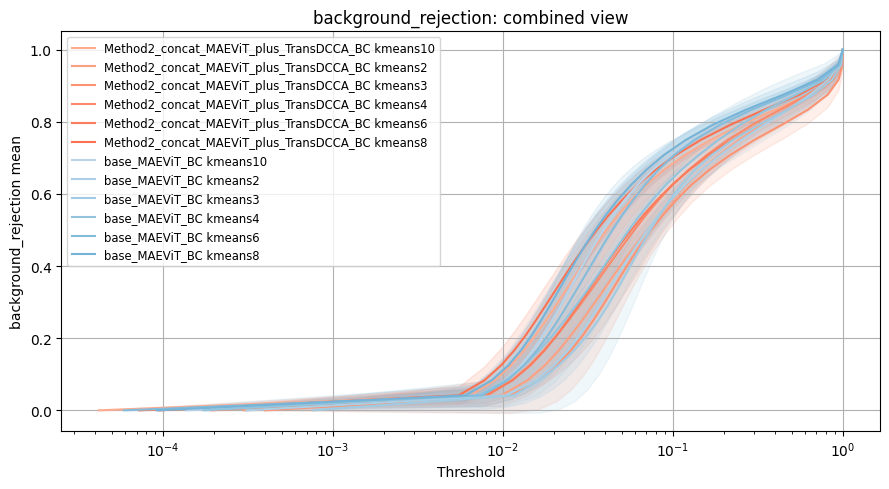

In [57]:
plot_pu_curve(summary, metric_name="background_rejection", include_tags=["base_MAEViT_BC", "Method2_concat_MAEViT_plus_TransDCCA_BC"],
              include_methods=["kmeans"],)

In [66]:
import matplotlib.pyplot as plt
import numpy as np

def plot_pu_npv(summary_dict, include_tags=None, include_methods=None, pi_keys=None):
    include_tags = set(include_tags) if include_tags else None
    include_methods = set(include_methods) if include_methods else None

    tag_palettes = {
        "base_MAEViT_BC": plt.cm.Blues,
        "Method2_concat_MAEViT_plus_TransDCCA_BC": plt.cm.Reds,
    }
    default_cmap = plt.cm.Greys

    entries = []
    for tag, methods in summary_dict.items():
        if include_tags and tag not in include_tags:
            continue
        for method, clusters in methods.items():
            if include_methods and method not in include_methods:
                continue
            for cluster, metrics in clusters.items():
                block = metrics.get("pu_npv")
                if not block:
                    continue
                entries.append((tag, method, int(cluster), block))

    if not entries:
        raise RuntimeError("No pu_npv data found for given filters.")

    plt.figure(figsize=(10, 5))

    for tag in sorted({e[0] for e in entries}):
        tag_entries = [e for e in entries if e[0] == tag]
        cmap = tag_palettes.get(tag, default_cmap)
        colors = cmap(np.linspace(0.35, 0.9, len(tag_entries)))
        for color, (tag, method, cluster, block) in zip(colors, tag_entries):
            npv = block.get("npv", {})
            thr = npv.get("thresholds")
            pi_stats = npv.get("pi_stats", [])
            if not thr or not pi_stats:
                continue
            active_pis = pi_keys or [entry["pi"] for entry in pi_stats]
            for entry in pi_stats:
                if entry["pi"] not in active_pis:
                    continue
                label = f"{tag} {method}{cluster} π={entry['pi']}"
                plt.plot(thr, entry["mean"], color=color, label=label)
                lower = [m - s for m, s in zip(entry["mean"], entry["std"])]
                upper = [m + s for m, s in zip(entry["mean"], entry["std"])]
                plt.fill_between(thr, lower, upper, color=color, alpha=0.15)

    plt.xscale("log")
    # plt.xscale("linear")
    plt.xlabel("Threshold")
    plt.ylabel("PU-NPV mean")
    plt.title("PU-NPV across tags/methods")
    handles, labels = plt.gca().get_legend_handles_labels()
    if handles:
        plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


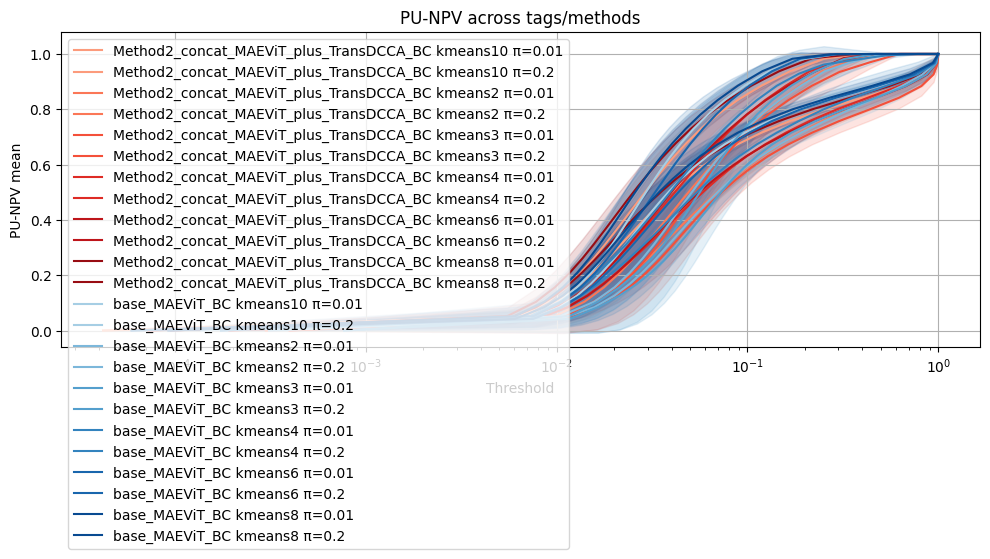

In [67]:
plot_pu_npv(summary,
            include_tags=["base_MAEViT_BC", "Method2_concat_MAEViT_plus_TransDCCA_BC"],
            include_methods=["kmeans"],
            pi_keys=[0.01, 0.2])